In [70]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as st
import scienceplots
plt.style.use(['science','grid'])

from dynamic_tasker.schedulers import *
from dynamic_tasker.access import *
from dynamic_tasker.orbits import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
h = 400
# os.chdir("./exploration")
requests = load_worldcities(10000)
t0 = datetime.datetime(2024, 1, 1, 0, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 2, 0, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)

np.random.seed(0)
for i, r in enumerate(accesses):
    r.state = {
        "occluded": np.random.randint(0, 2),
        "observed": False
        }

t_s = 5
t_dotsq = 4

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))


schedule_conv = milp_schedule(accesses, requests, agility_bangbang)
schedule_omni = milp_schedule([a for a in accesses if not a.state["occluded"]], requests, agility_bangbang)


In [206]:
# Now, sample the advantage
t_sample = 120
advantages = []

for i in range(100000):
    # Pick a random time...
    t = t0 + datetime.timedelta(seconds=np.random.randint(0, 24 * 3600))
    t_end = t + datetime.timedelta(seconds=t_sample)

    adv_omni = len([a for a in schedule_omni if a.time >= t and a.time <= t_end and not a.state["occluded"]])
    adv_conv = len([a for a in schedule_conv if a.time >= t and a.time <= t_end and not a.state["occluded"]])
    adv = adv_omni - adv_conv

    num_options = len([a for a in accesses if a.time >= t and a.time <= t_end and not a.state["occluded"]])

    advantages.append((adv, num_options))

In [ ]:
# Code the analytic advantage


def analytic_chain_probability(L, lam, M, c):
    """
    The renewal-process (Poisson process) approximation:
    We view the chain as starting at some point and then requiring M-1 gaps.
    Each gap is modeled as R = c + Exp(lam). The total additional waiting time is:
       S = (M-1)*c + Y, where Y ~ Gamma(M-1, rate=lam).
    For a chain to fit in [0,L] (ignoring where the chain starts), we require
       Y <= L - (M-1)*c.
    Thus the analytic probability is approximated by the Gamma CDF:
       P = GammaCDF( L - (M-1)*c; shape=M-1, scale=1/lam )
    Note: if L < (M-1)*c then P is zero.
    """
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

Average conv slew distance: 5.394691431693945
Average omni slew distance: 7.27662783389443


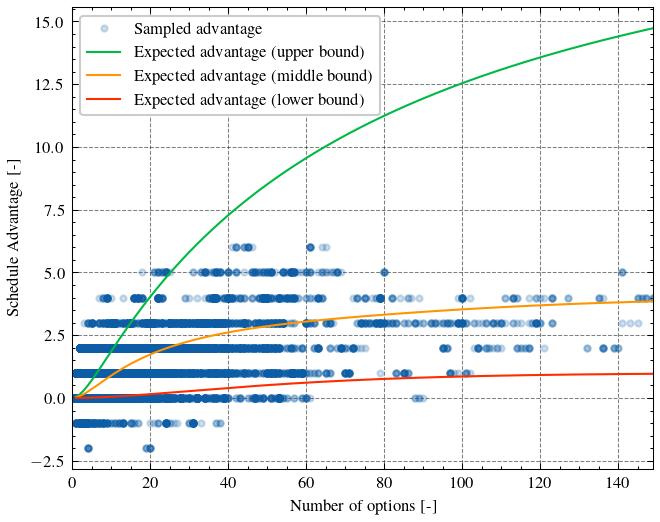

In [208]:

plt.figure(figsize=(5, 4), dpi=150)

# derive average slew distance...
slew_conv = np.median([np.abs(a.angle - b.angle) for a, b in zip(schedule_conv[:-1], schedule_conv[1:])])
slew_omni = np.median([np.abs(a.angle - b.angle) for a, b in zip(schedule_omni[:-1], schedule_omni[1:])])
print(f"Average conv slew distance: {slew_conv}")
print(f"Average omni slew distance: {slew_omni}")

N = np.arange(1, 150, 1)
max_a = 100
expected_advantage_ub = [expected_advantage(n, t_sample, t_s, 0, max_a) for n in N]
expected_advantage_mb = [expected_advantage(n, t_sample, agility_bangbang(15), 0, max_a) for n in N]
expected_advantage_lb = [expected_advantage(n, t_sample, 2 * agility_bangbang(30), 0, max_a) for n in N]

# Plot the regression line
plt.plot(np.array(advantages)[:, 1], np.array(advantages)[:, 0], '.', alpha=0.2, label="Sampled advantage")
# plt.plot(x_mavg, y_mavg, label="Moving average")

plt.plot(N, expected_advantage_ub, label="Expected advantage (upper bound)")
plt.plot(N, expected_advantage_mb, label="Expected advantage (middle bound)")
plt.plot(N, expected_advantage_lb, label="Expected advantage (lower bound)")

plt.xlim([0, N[-1]])
plt.ylabel("Schedule Advantage [-]")
plt.xlabel("Number of options [-]")
plt.legend()
plt.show()

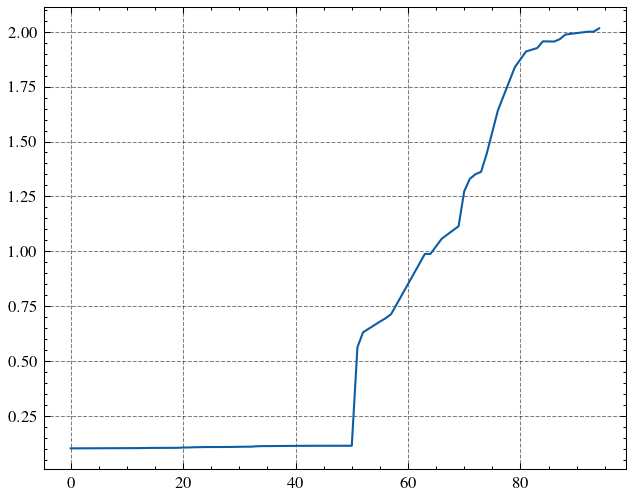

In [106]:
def moving_average_irregular(x, y, window_width):
    """
    Compute a moving average for irregularly spaced data.
    
    Parameters:
        x: array-like, independent variable values.
        y: array-like, dependent variable values.
        window_width: float, the width of the window in x units.
    
    Returns:
        y_avg: array of moving averages.
    """
    y_avg = np.empty_like(y, dtype=float)
    half_width = window_width / 2.0
    
    for i, x_val in enumerate(x):
        # Find indices where x is within the window centered at x_val
        indices = (x >= x_val - half_width) & (x <= x_val + half_width)
        y_avg[i] = np.mean(y[indices])
    
    return y_avg

sort_idx_x = np.sort(np.array(advantages)[:, 1])
sort_idx_y = np.array(advantages)[:, 0][np.argsort(np.array(advantages)[:, 1])]

avg_advantages = moving_average_irregular(sort_idx_x, sort_idx_y, 100)
plt.figure(figsize=(5, 4), dpi=150)


plt.plot(sort_idx_x, avg_advantages, label="Moving average")
plt.show()

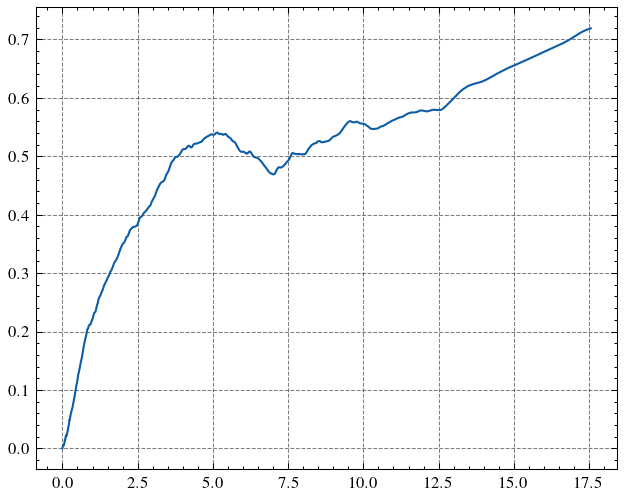

12.541103299080639
0.9999999999999865


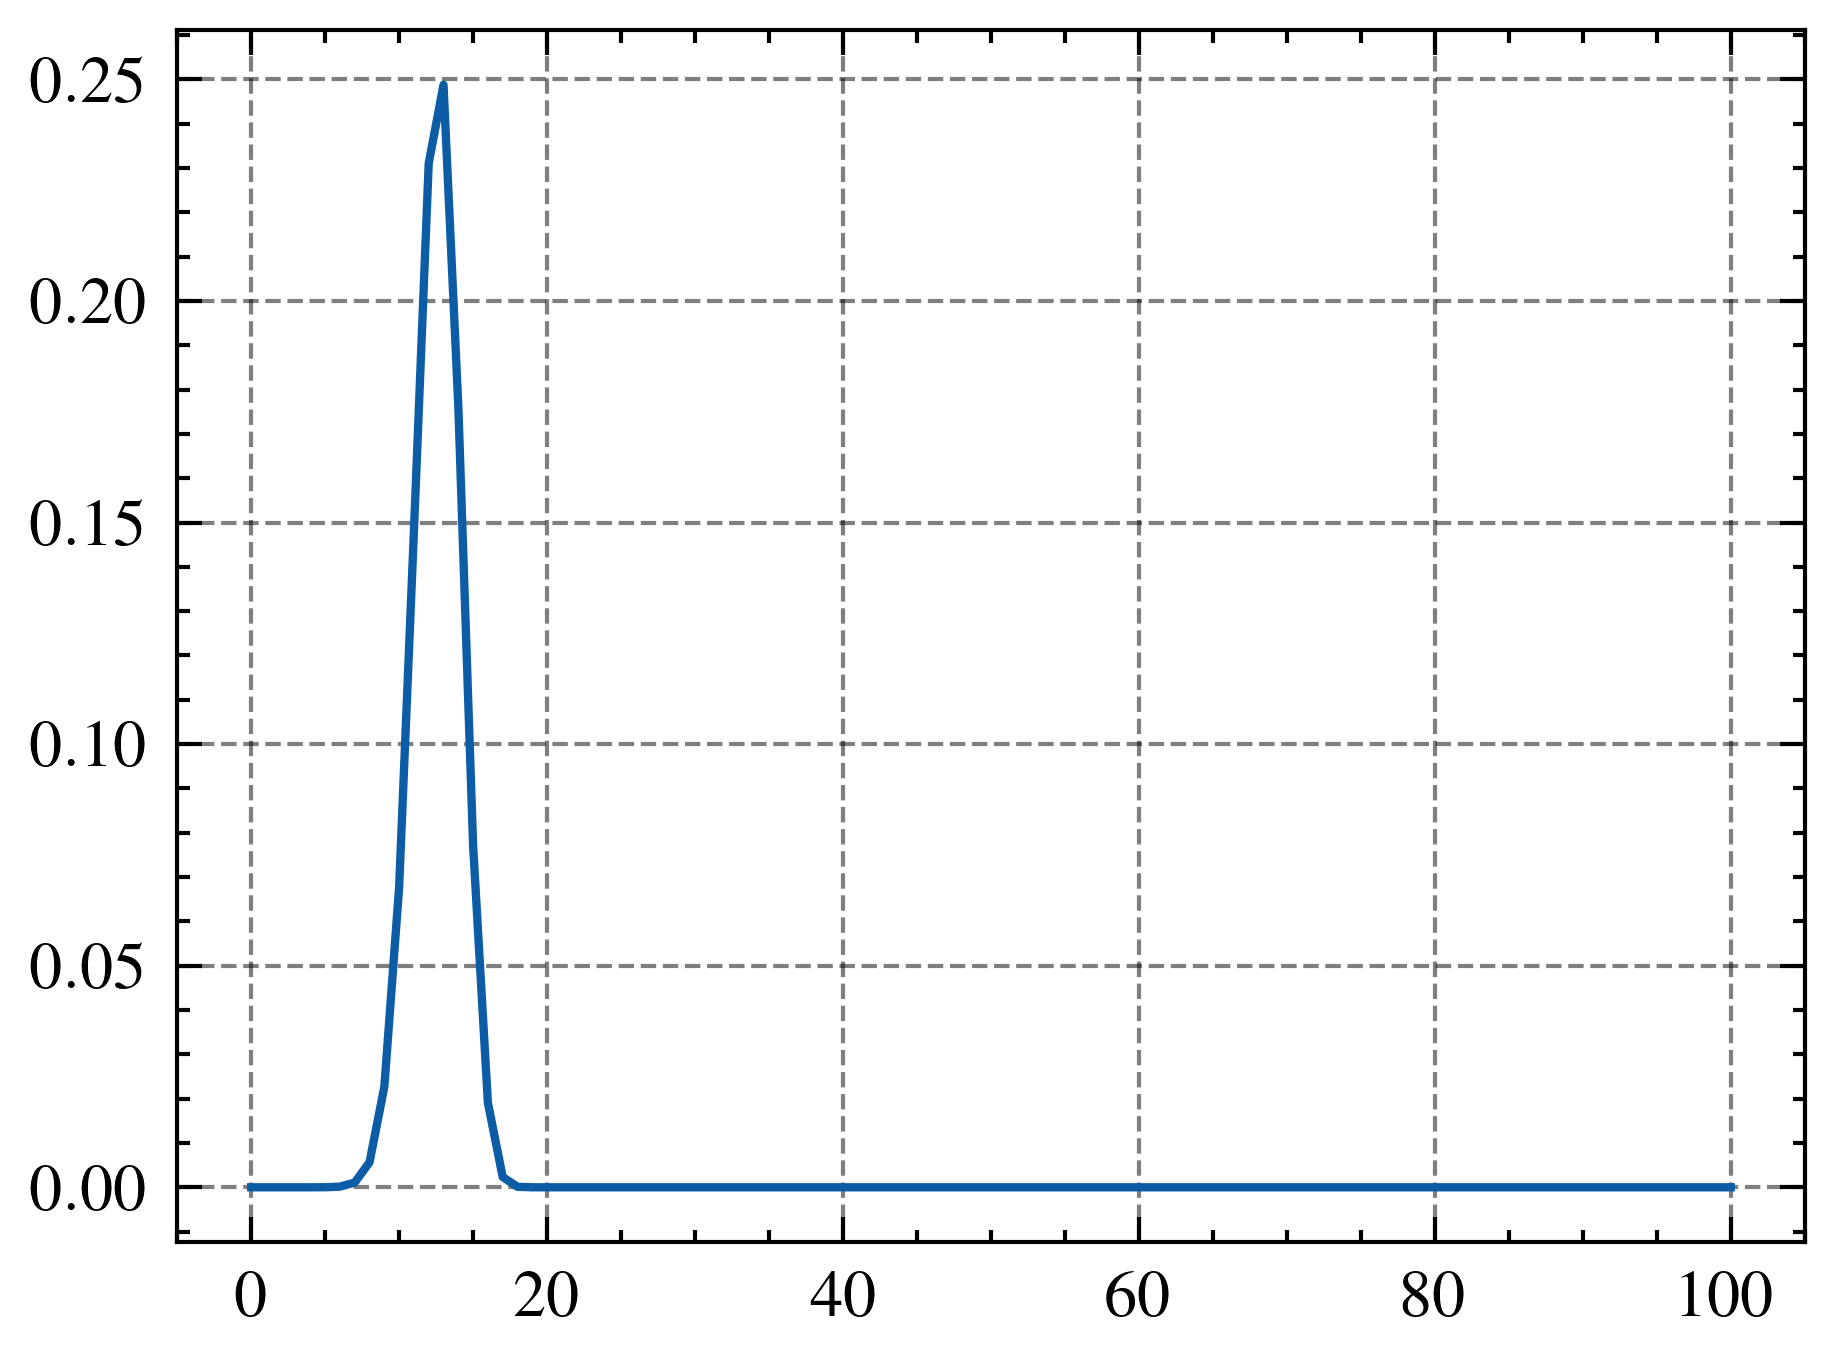

In [205]:
def expected_advantage_plot(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)


   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv), probabilities

N = 100
max_a = 100
t_sample = 120
t_s = 5
t_dotsq = 4
adv, probs = expected_advantage_plot(N, t_sample, t_s, 0, max_a)

print(adv)
print(np.sum(probs))

plt.plot(probs)
plt.show()